In [22]:
from IPython.display import Image, display

import json
import matplotlib.pyplot as plt

In [1]:
%%capture
# We need to alter the working directory to ./src to run the scripts
%cd ../src

# Training Mode

In this mode we train using the training set under `./data/train_scania.csv.gz`. Note that these data are not included in the repository due to their size and must be downloaded separately [here](https://drive.google.com/file/d/1LT_95MKmR57WAtpoC9VDZrmH_1kL6A1a/view?usp=sharing).

For demonstration purposes, I set `sample_n`=3 meaning, that each `vehicle_id` will be *downsampled* and observed three time. This downsampling is especially necessary with imbalanced panel data to ensure that vehicles with a large number of time series observations don't disproportionately affect the loss during training.

I also specify the data processor to include one lagged feature for each predictor feature, in order to account for some time series information.

In [4]:
!python -m pdm

[2025-05-13 13:44:49,586][root][INFO] - mode: train
data:
  data_path: ../data/train_scania.csv.gz
  unit_identifier: vehicle_id
  time_identifier: time_step
  target_feature: in_study_repair
  lag_length: 1
  sampling_n: 3
training_config:
  test_size: 0.15
  hyperoptimize: false
  n_trials: 30
  save_model: true
predict_config:
  model_path: <file>.zip
seed: 42

[2025-05-13 13:44:49,587][root][INFO] - Preprocessing data..
[2025-05-13 13:44:58,073][root][INFO] - Dropping degenerate features: ['Spec_4']
[2025-05-13 13:45:10,048][root][INFO] - Dropping highly correlated numeric features: {'397_4', '291_10', '397_10', '397_19', '397_15', '397_21', '291_1', '291_2', '397_11', '291_9', '397_16', '291_8', '397_14', '397_7', '397_12', '397_23'}
[2025-05-13 13:45:12,418][root][INFO] - Dropping strongly related categorical features: {'Spec_0'}
[2025-05-13 13:45:20,901][root][INFO] - Downsampling panel to min(3, len(x)) observations per 'vehicle_id'..
[2025-05-13 13:45:57,920][root][INFO] - Add

## Performance Metrics

#### Plotting the Loss

The loss for this model is the negative log likelihood. Below we see that the loss decreases by boosting iteration, which describes the the process by which additional boosted decision trees are added. However, we see some evidence of overfitting to the training set after about iteration 100. This could be combatted via hyperoptimization (not show) or potentially oversampling (this should be done separately before training).

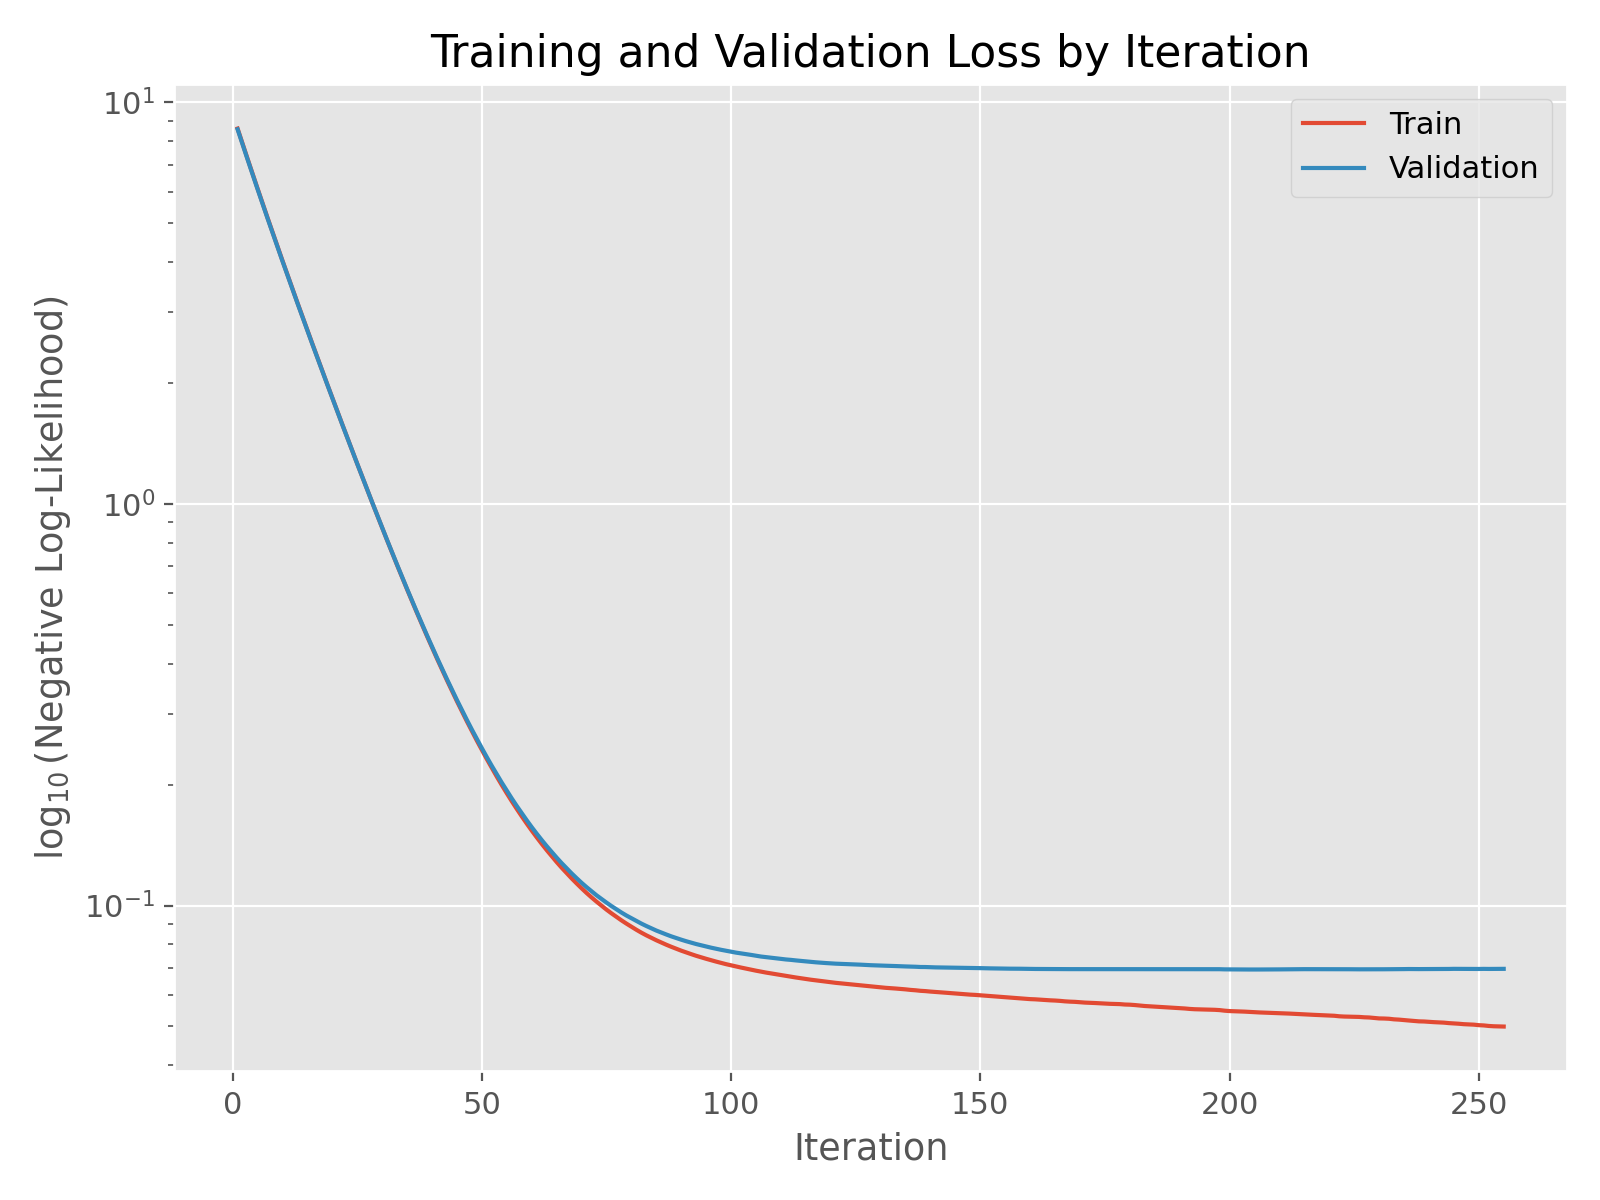

In [19]:
metrics_dir = '../outputs/2025-05-13/13-44-49'
display(Image(filename=metrics_dir+'/losses.png', width=1200))

#### Survival Curves

The **observed** survival curve below uses the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) on the *unduplicated* test set to estimate the failure rate across time, which also represents the probability of survival by timepoint. For this estimator, it's critical to use the last observation for each `vehicle_id` in our panel. Importantly, notice that we *do not observe* the median survival duration (i.e. <50% of observations are observed to have failed by the end) in these data, which generally complicates model training and inference. 

The **forecasted** survival curve represents the model's estimate median survival duration for all observations in the test set, averaged by timepoint. These forecasts are based on, in this case, the panel test set (i.e. not unduplicated).

A higher degree of similarity between the forecasted survival rate and the observed survival rate indicates the model does a good job in general of fitting the data.

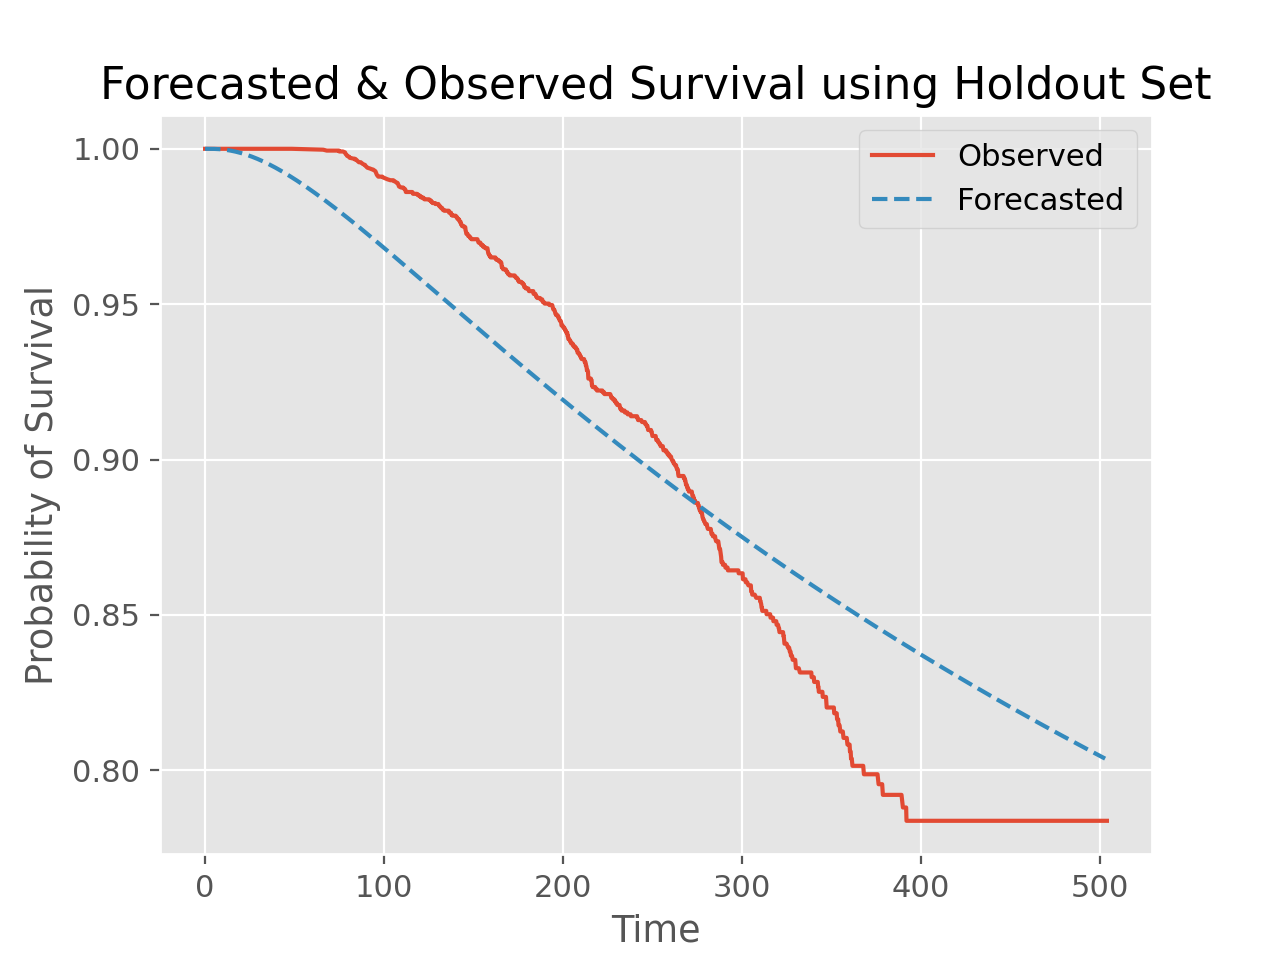

In [20]:
display(Image(filename=metrics_dir+'/survival_curves.png', width=1200))

### Concordance Index and Brier Score

[Concordance Index (c-index)](https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html): 

The concordance index or c-index is the most commonly used global performance metric in survival analysis. It is a ranking metric that measures a model's ability to correctly rank observations based on their risk of the outcome (discrimination).

It ranges from 0.5 (random guessing) to 1.0 (perfect) and measures the rank correlation between predicted risk scores, ŷ and observed time points y. It is defined as the ratio of correctly ordered (concordant) pairs to comparable pairs. Two samples i and j are comparable if the sample with lower observed time, y experienced an event, i.e. if y<sub>j</sub> > y<sub>i</sub> and δ=1, where δ<sub>i</sub> is a binary event indicator. A comparable pair (i, j) is concordant if the estimated risk ŷ by a survival model is higher for subjects with a lower observed survival time.

One well-known weakness of the traditional c-index (Harrell's) is that it tends to be too optimistic with an increasing amount of censoring. Because there is a large amount of censoring in the Scania data (>90%), I therefore use an adjusted concordance index proposed by Uno et al. 2011. This method estimates the inverse probability of being censored using the training set. I measure **test set performance using Uno's c-index**. The training set also uses this method, though using Uno’s c-index with weights derived from the same data yields results nearly identical to Harrell's estimator, since the IPC weights align with the empirical censoring distribution. **Note** - the c-index of model prediction in predict mode (below) uses weights derived from the same prediction dataset, meaning this c-index is nearly identical to Harrell's estimator too.

[Brier Score](https://en.wikipedia.org/wiki/Brier_score):

A major weakness of ranking metrics, such as the c-index, is that they do not account for the accuracy of predicted survival probabilities (i.e. calibration). Ranging between 0 (perfect) and 1 (worst), the Brier score measures the calibration of survival probabilities. The Brier score is time-specific, meaning it explicitly considers predictions at a particular point in time. Therefore, it is common to integrate across a time interval. I report the integrated Brier score across the whole time horizon for the test set below.

In [25]:
with open(metrics_dir+'/metrics.json') as f:
    metrics = json.load(f)

print('Metrics:')
for key, value in metrics.items():
    print(f'{key}: {value}')

Metrics:
Concordance Index: {'train': 0.9150941826111417, 'test': 0.7755857527287976}
Integrated Brier Score: 0.06606229884803494


# Prediction Mode

Predict (inference) mode works similarly to training mode, except that we must update two parameters in [`./configs/config.yaml`](../configs/config.yaml):

- `mode`: set this from train to predict
- `data_path`: this should point to the prediction dataset. In this case, I use a holdout set that was constructed in [this notebook](data_merging.ipynb) and can be downloaded [here](https://drive.google.com/file/d/1IchHJmjbKQDkpLVGWfpx-PIoHr3NhUGu/view?usp=sharing)

- `model_path`: must point to the zipped directory containing previously-trained model artifacts

Model artifacts include:
- `feature_list.json`: used to limit the prediction dataset to the same features as those used for training. Prior to training features may be dropped for high multicollinearity or lack of variation.
- `config.yaml`: includes information about training (necessary for contruction of survival curves), feature lags, and panel downsampling
- `minmax_scaler.joblib`: used to min-max normalize the prediction data using the feature information from the training set
- `xgboost_model.json`: actual XGBoost survival model

In [29]:
!python -m pdm

[2025-05-14 09:51:30,441][root][INFO] - mode: predict
data:
  data_path: ../data/test_scania.csv.gz
  unit_identifier: vehicle_id
  time_identifier: time_step
  target_feature: in_study_repair
  lag_length: 1
  sampling_n: 3
training_config:
  test_size: 0.15
  hyperoptimize: false
  n_trials: 30
  save_model: true
predict_config:
  model_path: ../outputs/2025-05-13/13-44-49/data_model_artifacts.zip
seed: 42

[2025-05-14 09:51:30,442][root][INFO] - Transforming data for prediction..
[2025-05-14 09:51:30,620][root][INFO] - Downsampling panel to min(3, len(x)) observations per 'vehicle_id'..
[2025-05-14 09:51:31,241][root][INFO] - Adding lags up to 1 periods..
[2025-05-14 09:51:31,872][root][INFO] - Data transformation complete, took: 1.43 seconds. 

[2025-05-14 09:51:31,914][root][INFO] - Concordance Index (test): 0.6642
[2025-05-14 09:51:32,055][root][INFO] - Integrated Brier Score: 0.0702
[2025-05-14 09:51:32,068][root][INFO] - Total run time: 1.63 seconds. 



## Survival Curves of Holdout Set

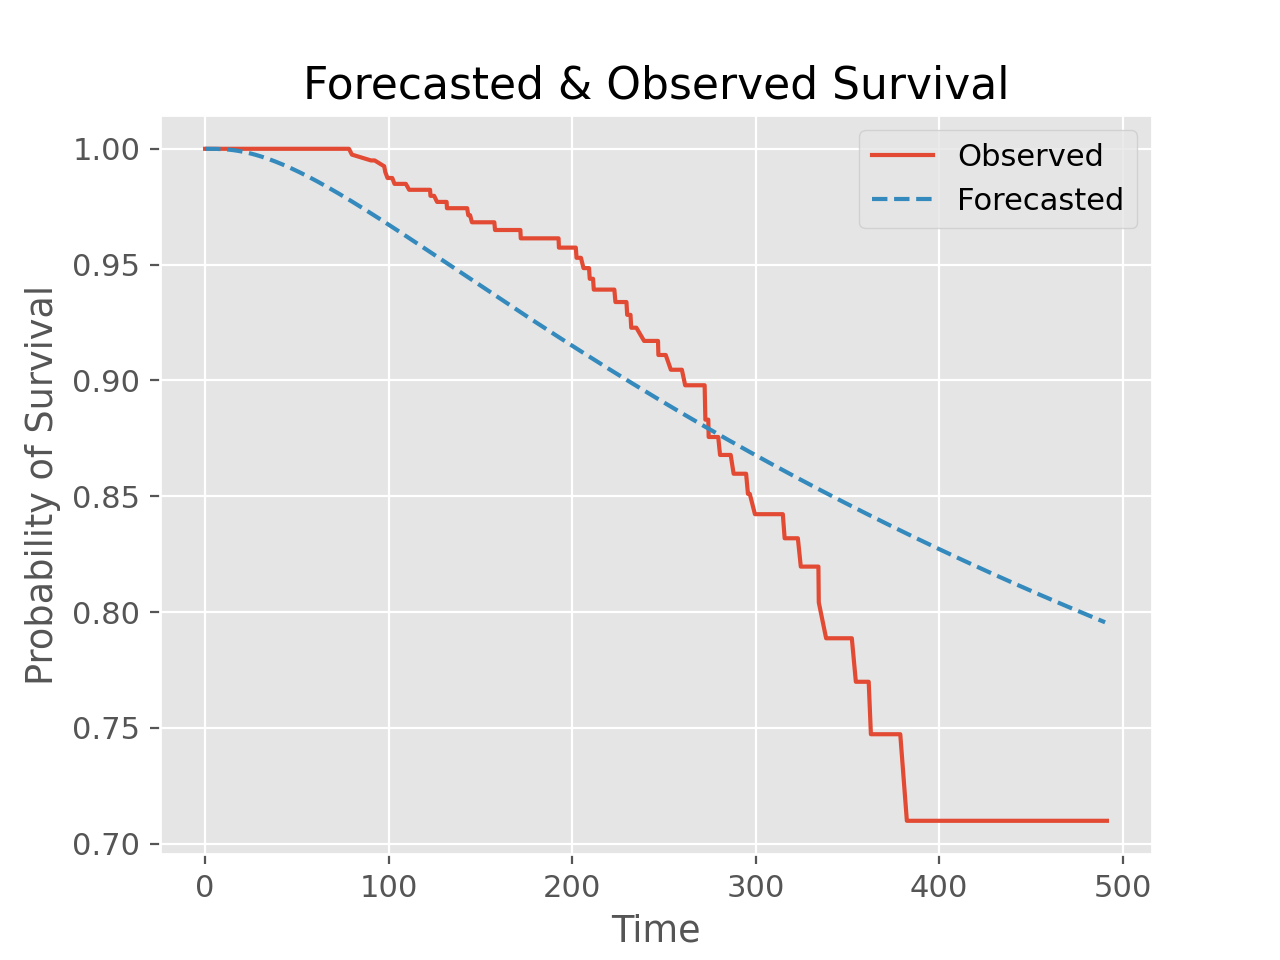

In [ ]:
metrics_dir2 = '../outputs/2025-05-14/09-51-30'
display(Image(filename=metrics_dir2+'/survival_curves.png', width=1200))